In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download the Dataset for Inferencing

In [ ]:
# install kaggle
!pip install -q kaggle

In [ ]:
# create kaggle folder
!mkdir ~/.kaggle

# copy the kaggle.json to the folder created
!cp /content/drive/MyDrive/Colab_Notebooks/Kaggle_API_Token/kaggle.json ~/.kaggle/

# permission for the jason to act
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Loading the dataset using Kaggle API Command
!kaggle datasets download -d chitholian/annotated-potholes-dataset

 54% 25.0M/45.9M [00:00<00:00, 53.3MB/s]
100% 45.9M/45.9M [00:00<00:00, 89.3MB/s]


In [ ]:
# Unzipping the dataset
!unzip /content/annotated-potholes-dataset.zip

# Setup for YoloV5

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.8/78.2 GB disk)


In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

# Load the model

In [ ]:
pretrained_model_path = '/content/drive/MyDrive/Colab_Notebooks/Object_Detection/YoloV5/YoloV5_Pothole/best.pt'

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom',
                       path = pretrained_model_path, force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 444 layers, 86173414 parameters, 0 gradients
Adding AutoShape... 


# Do Detection

#### Define Custom Functions

In [ ]:
import cv2

def draw_focused_rectangle(image, bbox, color, corner_length = 30, corner_thickness = 4, edge_thickness = 1):
    img = image.copy()

    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if (x1+corner_length > x2) or (y1+corner_length > y2):
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
    else:
        cv2.rectangle(img, (x1, y1), (x2, y2), color = color, thickness = edge_thickness)
        # top left corner
        cv2.line(img, (x1, y1), (x1+corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y1), (x1, y1+corner_length), color = color, thickness = corner_thickness)
        # top right corner
        cv2.line(img, (x2, y1), (x2-corner_length, y1), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y1), (x2, y1+corner_length), color = color, thickness = corner_thickness)
        # bottom left corner
        cv2.line(img, (x1, y2), (x1+corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x1, y2), (x1, y2-corner_length), color = color, thickness = corner_thickness)
        # bottom right corner
        cv2.line(img, (x2, y2), (x2-corner_length, y2), color = color, thickness = corner_thickness)
        cv2.line(img, (x2, y2), (x2, y2-corner_length), color = color, thickness = corner_thickness)

    return img

def draw_label(image, label, x, y, box_color, font_color, font_face = cv2.FONT_HERSHEY_SIMPLEX, font_scale = .75):
    img = image.copy()

    text_size = cv2.getTextSize(label, fontFace=font_face, fontScale=font_scale, thickness=2)
    dim, baseline = text_size[0], text_size[1]
    
    # cv2.rectangle(img, (x,y), (x + dim[0], y + dim[1] + baseline), box_color, cv2.FILLED);
    # cv2.putText(img, label, (x, y + dim[1] + 2), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=1)

    cv2.rectangle(img, (x, y - dim[1] - baseline), (x + dim[0], y), box_color, cv2.FILLED);
    cv2.putText(img, label, (x, y - dim[1] + 10), fontFace=font_face, fontScale=font_scale, color=font_color, thickness=2)

    return img

In [ ]:
def detect_image(image_bgr, yolov5_model, detection_threshold, classes, colors):
    img = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    results = yolov5_model(img)
    detections = results.crop(save = False)

    if len(detections) == 0:
        return image_bgr

    for i in range(len(detections)):
        if detections[i]['conf'].cpu().numpy() >= detection_threshold:
            xmin = int(detections[i]['box'][0].cpu().numpy())
            ymin = int(detections[i]['box'][1].cpu().numpy())
            xmax = int(detections[i]['box'][2].cpu().numpy())
            ymax = int(detections[i]['box'][3].cpu().numpy())
            cls_id = int(detections[i]['cls'].cpu().numpy())
            conf = int(detections[i]['conf'].cpu().numpy()*100)
            cls = classes[cls_id]
            color = colors[cls][::-1]
            label = f'{cls}: {conf}%'
            
            # cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color = color, thickness = 2)
            img = draw_focused_rectangle(img, (xmin, ymin, xmax, ymax), color)
            img = draw_label(img, label, xmin, ymin, color, (255,255,255))

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return img

#### Define the classes and their colors

In [ ]:
classes = {0: 'pothole'}
colors = {'pothole': (0,50,255)} #BGR

#### Detection on Image

In [ ]:
import os
import random

DATA_SOURCE_PATH = '/content/annotated-images'
IMAGES_PATHS = [DATA_SOURCE_PATH + '/' + fil for fil in os.listdir(DATA_SOURCE_PATH) if os.path.splitext(fil)[1] == '.jpg']
SAMPLE_IMAGE_PATH = random.sample(IMAGES_PATHS, 1)[0]
print(os.path.basename(SAMPLE_IMAGE_PATH))

img-4.jpg


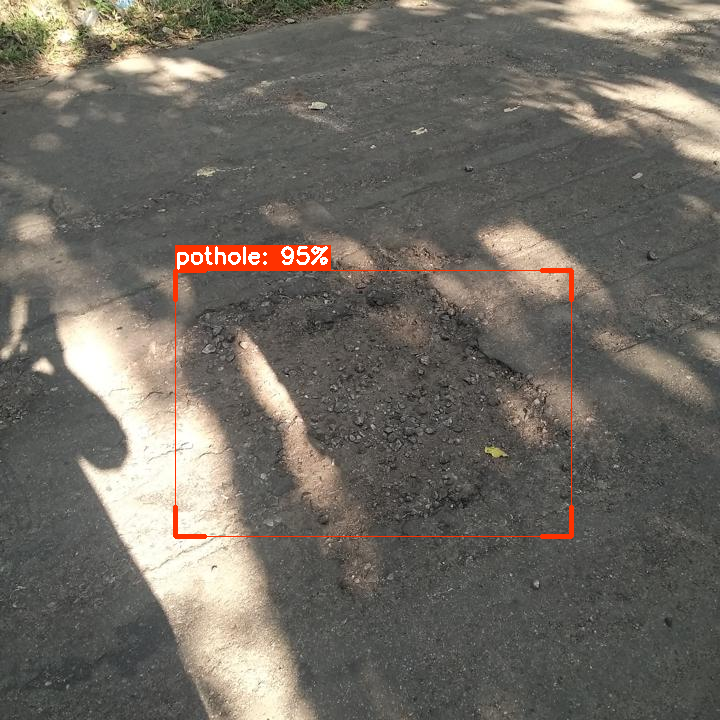

In [ ]:
from google.colab.patches import cv2_imshow

image = cv2.imread(SAMPLE_IMAGE_PATH)
detected_image = detect_image(image, model, 0.4, classes, colors)

cv2_imshow(detected_image)